In [1]:
import mezzala
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to transform the data into JSON with scorelines included
def transform_json(row):
    return {
        "date": row["Date"],
        "team1": row["Home"],
        "team2": row["Away"],
        "score": {"ft": [row["HG"], row["AG"]]}
    }

# Function to simulate a single season, taking as input Mezzala model and a JSON list
def simulate_single_season(model, df):
    
    # Create an empty list to store the results
    matches = []

    # Get scoreline combinations for all matches at once
    scorelines_all_matches = model.predict(df)

    # Iterate over each match's scorelines
    for match_index, scorelines in enumerate(scorelines_all_matches):
        
        # Extract probabilities and create a list of corresponding scorelines
        probabilities = [scoreline.probability for scoreline in scorelines]
        possible_scorelines = [(scoreline.home_goals, scoreline.away_goals, scoreline.probability) for scoreline in scorelines]
        
        # Choose a random scoreline based on the probabilities
        chosen_scoreline = random.choices(possible_scorelines, weights=probabilities)[0]
        
        # Get match information
        match_row = df[match_index]
        
        # Append the chosen scoreline to the results list
        matches.append({
            'Date': match_row['date'],
            'Home': match_row['team1'],
            'Away': match_row['team2'],
            'HG': chosen_scoreline[0],
            'AG': chosen_scoreline[1],
            'Prob': round(chosen_scoreline[2]*100, 2)
        })

    # Convert the results list to a DataFrame
    matches = pd.DataFrame(matches)
    
    return matches

# Same as the above, but simulates N seasons
def simulate_multiple_seasons(model, df, amount):
    
    # Initialize an empty list to store the results DataFrames
    matches_dfs = []

    # Run the simulate_season function 100 times
    for i in range(amount):
        # Call the simulate_season function and append the resulting DataFrame to the list
        matches_dfs.append(simulate_single_season(model, df))
        
    return matches_dfs

# Function to calculate standings for a single season, taking as input a dataframe of matches
def calculate_standings_single_season(sim):
    team_stats = {}

    for index, row in sim.iterrows():
        home_team = row['Home']
        away_team = row['Away']
        home_goals = row['HG']
        away_goals = row['AG']
        
        # Update or initialize stats for home team
        if home_team in team_stats:
            team_stats[home_team]['GF'] += home_goals
            team_stats[home_team]['GA'] += away_goals
            team_stats[home_team]['GD'] += (home_goals - away_goals)
            team_stats[home_team]['PTS'] += (3 if home_goals > away_goals else (1 if home_goals == away_goals else 0))
            team_stats[home_team]['P'] += 1
        
            if home_goals > away_goals:
                team_stats[home_team]['W'] += 1
            elif home_goals == away_goals:
                team_stats[home_team]['D'] += 1
            else:
                team_stats[home_team]['L'] += 1
        else:
            team_stats[home_team] = {'GF': home_goals, 'GA': away_goals, 'GD': (home_goals - away_goals),
                                    'PTS': (3 if home_goals > away_goals else (1 if home_goals == away_goals else 0)),
                                    'P': 1, 'W': 1 if home_goals > away_goals else 0,
                                    'D': 1 if home_goals == away_goals else 0, 'L': 1 if home_goals < away_goals else 0}

        # Update or initialize stats for away team
        if away_team in team_stats:
            team_stats[away_team]['GF'] += away_goals
            team_stats[away_team]['GA'] += home_goals
            team_stats[away_team]['GD'] += (away_goals - home_goals)
            team_stats[away_team]['PTS'] += (3 if away_goals > home_goals else (1 if away_goals == home_goals else 0))
            team_stats[away_team]['P'] += 1
            
            if away_goals > home_goals:
                team_stats[away_team]['W'] += 1
            elif away_goals == home_goals:
                team_stats[away_team]['D'] += 1
            else:
                team_stats[away_team]['L'] += 1
        else:
            team_stats[away_team] = {'GF': away_goals, 'GA': home_goals, 'GD': (away_goals - home_goals),
                                    'PTS': (3 if away_goals > home_goals else (1 if away_goals == home_goals else 0)),
                                    'P': 1, 'W': 1 if away_goals > home_goals else 0,
                                    'D': 1 if away_goals == home_goals else 0, 'L': 1 if away_goals < home_goals else 0}

    standings = pd.DataFrame.from_dict(team_stats, orient='index')
    standings.index.name = 'Team'

    # Calculate additional stats like Goal Difference, Wins, Draws, Losses, and Points Percentage
    standings['GD'] = standings['GF'] - standings['GA']
    standings['%'] = round((standings['PTS'] / (standings['P'] * 3)) * 100, 1)

    # Sort the standings by Points, Goal Difference, and Goals For
    standings = standings.sort_values(by=['PTS', 'GD', 'GF'], ascending=False)

    # Add Position (Pos) column
    standings.reset_index(inplace=True)
    standings['Pos'] = standings.index + 1
    standings.set_index('Pos', inplace=True)
    standings.index.name = 'Pos'
    standings = standings[['Team', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']]
    standings.reset_index(inplace=True)

    return standings

# Same as the above, but for N seasons, taking as input a list of dataframes of matches
def calculate_standings_multiple_seasons(season_dfs):
    standings_dfs = []

    # Iterate over each DataFrame in the list
    for df in season_dfs:
        standings_dfs.append(calculate_standings_single_season(df))

    return standings_dfs

# Function to calculate the difference between a simulated season and the real life one
def difference_sim_to_real(standings_df_list, real_standings):
    
    errors = []
    
    # Iterate over each standings DataFrame in standings_df_list
    for i, standings_df in enumerate(standings_df_list):
        
        # Perform comparison with real standings
        comparison = pd.merge(standings_df, real_standings, on='Team')
        
        # Calculate the absolute difference for each desired column
        for col in ['Pos', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD']:
            comparison[col] = abs(comparison[col + '_x'] - comparison[col + '_y'])
        
        # Drop the columns with suffixes _x and _y
        comparison = comparison.drop(columns=[col + '_x' for col in ['Pos', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD']])
        comparison = comparison.drop(columns=[col + '_y' for col in ['Pos', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD']])
        
        # Calculate the sum of absolute differences for PTS
        PTS_error = comparison['PTS'].sum()
        
        # Store the index of standings_df and its PTS_error value
        errors.append({'Index': i, 'PTS Error': PTS_error})
    
    # Create a DataFrame from the results
    errors = pd.DataFrame(errors)
    
    # Create a Prob column
    # The smaller the Error, the higher the Prob
    errors['Prob'] = 1 / errors['PTS Error']
    errors['Prob'] = errors['Prob'] / errors['Prob'].sum()
    
    return errors

# Function to calculate Euclidean distance between dataframes
def euclidean_distance(df1, df2):
    if df1.shape != df2.shape:
        raise ValueError("Dataframes must have the same shape")

    # Calculate squared differences element-wise
    squared_diff = (df1 - df2) ** 2

    # Calculate RMSE (square root of mean of squared differences)
    rmse = np.sqrt(np.mean(squared_diff.values))
    return rmse

# Function to run the Montecarlo simulation
def montecarlo(df, year, amount):
    
    real_matches = df[df.Year == year]
    real_standings = calculate_standings_single_season(real_matches)

    # Transforming the data into the JSON required by Mezzala package
    json = real_matches.apply(transform_json, axis=1).tolist()

    # Creating the adapter and fitting the model
    adapter = mezzala.KeyAdapter(home_team='team1', away_team='team2', home_goals=['score', 'ft', 0], away_goals=['score', 'ft', 1])
    model = mezzala.DixonColes(adapter=adapter)
    model.fit(json)
    
    # Simulating N seasons
    sim = simulate_multiple_seasons(model, json, amount)
    for i, df in enumerate(sim):
        df['Iteration'] = i

    all_matches = pd.concat(sim)
    all_matches.reset_index(drop=True, inplace=True)
    
    # Calculating standings for each season
    standings = calculate_standings_multiple_seasons(sim)
    for i, df in enumerate(standings):
        df['Iteration'] = i

    all_standings = pd.concat(standings)
    all_standings.reset_index(drop=True, inplace=True)
    
    # Getting the difference between each simulated season and the real life one
    diff = difference_sim_to_real(standings, real_standings)
    
    # Choosing an iteration using similarity as probability weight
    chosen_index = random.choices(diff['Index'].tolist(), weights=diff['Prob'].tolist())[0]
    
    # Using the chosen index to select one of the N simulations
    matches_df = sim[chosen_index] # Simulated matches in the chosen iteration
    standings_df = standings[chosen_index] # Standings of the chosen iteration
    
    # Calculating the average standings of the N simulations
    average_df = all_standings.groupby('Team').mean().reset_index()
    average_df = average_df.sort_values(by=['PTS', 'W', 'GD', 'GF'], ascending=[False, False, False, False])
    average_df.reset_index(drop=True, inplace=True)
    average_df['Pos'] = average_df.index + 1

    # Counting how many times each team finished in each position
    # Create an empty dictionary to store the counts for each team in each 'Pos'
    team_pos_counts = {}

    # Iterate over each dataframe in the standings list
    for df in standings:
        # Iterate over each row in the dataframe
        for index, row in df.iterrows():
            team = row['Team']
            pos = row['Pos']
            
            # Update the counts dictionary
            if team not in team_pos_counts:
                team_pos_counts[team] = {}
            if pos not in team_pos_counts[team]:
                team_pos_counts[team][pos] = 0
            team_pos_counts[team][pos] += 1

    # Convert the dictionary to a dataframe
    team_pos_counts_df = pd.DataFrame.from_dict(team_pos_counts, orient='index')

    # Fill NaN values with 0
    team_pos_counts_df.fillna(0, inplace=True)

    # Convert float values to integers
    team_pos_counts_df = team_pos_counts_df.astype(int)
    
    # Extract the 'Team' column from the dataframe
    teams = team_pos_counts_df.index

    # Get the maximum position found in the data
    max_pos = team_pos_counts_df.columns.max()

    # Reindex the dataframe to show positions 1, 2, 3, 4, ...
    new_columns = range(1, max_pos + 1)
    team_pos_counts_df = team_pos_counts_df.reindex(columns=new_columns, fill_value=0)

    # Sort the dataframe columns based on the positions from 1 to max_pos
    sorted_positions = sorted(team_pos_counts_df.columns, key=lambda x: int(x))

    # Reindex the team_pos_counts_df based on the sorted positions
    team_pos_counts_df_sorted = team_pos_counts_df.reindex(columns=sorted_positions)

    # Sort the dataframe by the values in each position
    team_pos_counts_df_sorted = team_pos_counts_df_sorted.sort_values(by=team_pos_counts_df_sorted.columns.tolist(), axis=0, ascending=False)
    
    ### Calculating biggest wins
    all_matches['Margin'] = abs(all_matches['HG'] - all_matches['AG'])
    all_matches_sorted = all_matches.sort_values(by='Margin', ascending=False)
    top_50_wins = all_matches_sorted.head(50)
    
    return real_matches, real_standings, matches_df, standings_df, all_matches, all_standings, average_df, team_pos_counts_df_sorted, top_50_wins

# Function to simulate a single PARTIAL season, taking as input Mezzala model and a JSON list
def simulate_single_partial_season(model, json_test, df_train):
    
    # Create an empty list to store the results
    sim_matches = []

    # Get scoreline combinations for all matches at once
    scorelines_all_matches = model.predict(json_test)

    # Iterate over each match's scorelines
    for match_index, scorelines in enumerate(scorelines_all_matches):
        
        # Extract probabilities and create a list of corresponding scorelines
        probabilities = [scoreline.probability for scoreline in scorelines]
        possible_scorelines = [(scoreline.home_goals, scoreline.away_goals, scoreline.probability) for scoreline in scorelines]
        
        # Choose a random scoreline based on the probabilities
        chosen_scoreline = random.choices(possible_scorelines, weights=probabilities)[0]
        
        # Get match information
        match_row = json_test[match_index]
        
        # Append the chosen scoreline to the results list
        sim_matches.append({
            'Date': match_row['date'],
            'Home': match_row['team1'],
            'Away': match_row['team2'],
            'HG': chosen_scoreline[0],
            'AG': chosen_scoreline[1],
            'Prob': round(chosen_scoreline[2]*100, 2)
        })

    # Convert the results list to a DataFrame
    sim_matches = pd.DataFrame(sim_matches)
    
    # Getting the real matches
    real_matches = df_train[['Date', 'Home', 'Away', 'HG', 'AG']].copy()
    real_matches['Prob'] = 1
    
    # Merging both
    matches = pd.concat([real_matches, sim_matches], ignore_index=True)
    
    return matches
# Same as the above, but simulates N partial seasons
def simulate_multiple_partial_seasons(model, json_test, df_train, amount):
    
    # Initialize an empty list to store the results DataFrames
    matches_dfs = []

    # Run the simulate_season function 100 times
    for i in range(amount):
        # Call the simulate_season function and append the resulting DataFrame to the list
        matches_dfs.append(simulate_single_partial_season(model, json_test, df_train))
        
    return matches_dfs

# Partial Montecarlo
def partial_montecarlo(df_train, df_test, amount):

    # Transforming the data into the JSON required by Mezzala package
    json_train = df_train.apply(transform_json, axis=1).tolist()
    json_test = df_test.apply(transform_json, axis=1).tolist()

    # Creating the adapter and fitting the model
    adapter = mezzala.KeyAdapter(home_team='team1', away_team='team2', home_goals=['score', 'ft', 0], away_goals=['score', 'ft', 1])
    model = mezzala.DixonColes(adapter=adapter)
    model.fit(json_train)

    # Simulating N seasons
    sim = simulate_multiple_partial_seasons(model, json_test, df_train, amount)
    
    # Calculating standings for each season
    standings = calculate_standings_multiple_seasons(sim)
    
    # Calculating the average standings of the N simulations
    all_standings = pd.concat(standings)
    average_df = all_standings.groupby('Team').mean().reset_index()
    average_df = average_df.sort_values(by=['PTS', 'W', 'GD', 'GF'], ascending=[False, False, False, False])
    average_df.reset_index(drop=True, inplace=True)
    average_df['Pos'] = average_df.index + 1
    average_df = average_df.round({col: 0 if col != '%' else 1 for col in average_df.columns})

    # Counting how many times each team finished in each position
    # Create an empty dictionary to store the counts for each team in each 'Pos'
    team_pos_counts = {}

    # Iterate over each dataframe in the standings list
    for df in standings:
        # Iterate over each row in the dataframe
        for index, row in df.iterrows():
            team = row['Team']
            pos = row['Pos']
            
            # Update the counts dictionary
            if team not in team_pos_counts:
                team_pos_counts[team] = {}
            if pos not in team_pos_counts[team]:
                team_pos_counts[team][pos] = 0
            team_pos_counts[team][pos] += 1

    # Convert the dictionary to a dataframe
    team_pos_counts_df = pd.DataFrame.from_dict(team_pos_counts, orient='index')

    # Fill NaN values with 0
    team_pos_counts_df.fillna(0, inplace=True)

    # Convert float values to integers
    team_pos_counts_df = team_pos_counts_df.astype(int)
    
    # Extract the 'Team' column from the dataframe
    teams = team_pos_counts_df.index

    # Get the maximum position found in the data
    max_pos = team_pos_counts_df.columns.max()

    # Reindex the dataframe to show positions 1, 2, 3, 4, ...
    new_columns = range(1, max_pos + 1)
    team_pos_counts_df = team_pos_counts_df.reindex(columns=new_columns, fill_value=0)

    # Sort the dataframe columns based on the positions from 1 to max_pos
    sorted_positions = sorted(team_pos_counts_df.columns, key=lambda x: int(x))

    # Reindex the team_pos_counts_df based on the sorted positions
    team_pos_counts_df_sorted = team_pos_counts_df.reindex(columns=sorted_positions)

    # Sort the dataframe by the values in each position
    team_pos_counts_df_sorted = team_pos_counts_df_sorted.sort_values(by=team_pos_counts_df_sorted.columns.tolist(), axis=0, ascending=False)
    
    return average_df, team_pos_counts_df_sorted

#

# Re-simulating past championships

In [ ]:
# Creating the results
# real_matches - Real life matches played
# real_standings - Real life standings
# matches - List of matches played in the chosen iteration
# standings - Standings of the chosen iteration
# average_df - Average standings among all the N iterations
# team_positions - Amount of times each team finished in each position
# top_10_wins_margins - Biggest wins among all the N iterations

data = pd.read_csv("england.csv", sep=';', encoding='latin1')
years = data['Year'].unique().tolist()

for year in years:
    real_matches, real_standings, matches, standings, all_matches, all_standings, average_df, team_positions, top_50_wins = montecarlo(data, year, 2)
    file_name = f"Premier League {year-1}-{year}.xlsx"
    with pd.ExcelWriter(file_name) as writer:
        real_matches.to_excel(writer, sheet_name='Real matches')
        real_standings.to_excel(writer, sheet_name='Real standings')
        matches.to_excel(writer, sheet_name='Matches')
        standings.to_excel(writer, sheet_name='Standings')
        all_matches.to_excel(writer, sheet_name='All matches')
        all_standings.to_excel(writer, sheet_name='All standings')
        average_df.to_excel(writer, sheet_name='Average standings')
        team_positions.to_excel(writer, sheet_name='Team positions')
        top_50_wins.to_excel(writer, sheet_name='Top 50 wins')

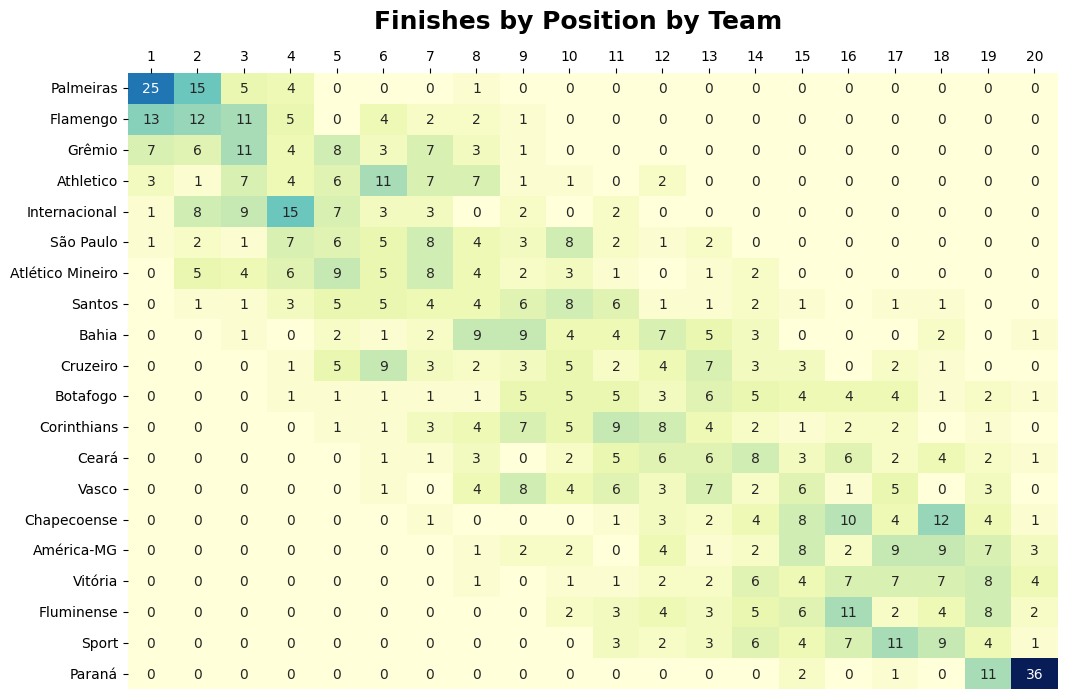

In [5]:
# Set the size of the heatmap
plt.figure(figsize=(12, 8))

# Plot the heatmap using the index for the y-axis
heatmap = sns.heatmap(team_positions, cmap="YlGnBu", annot=True, fmt="d", cbar=False)

# Set the title and labels
plt.suptitle('Finishes by Position by Team', y=0.96, weight='bold', size=18)
heatmap.xaxis.tick_top()
plt.xlabel('')
plt.ylabel('')
plt.show()

# Simulating on-going

In [56]:
# Importing data
data = pd.read_csv("premier-league-matches.csv", sep=';', encoding='latin1')
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

# Creating a dataframe for the year and splitting into train and test
# In this case, the train data is the first 30 weekdays
# The test data is the last 8 weekdays
df_year = data[data.Year == 2019]
df_train = df_year[df_year.Wk <= 30]
df_test = df_year[df_year.Wk > 30]
real_standings = calculate_standings_single_season(df_year)

# Simulating
average_df, team_positions = partial_montecarlo(df_train, df_test, 100)

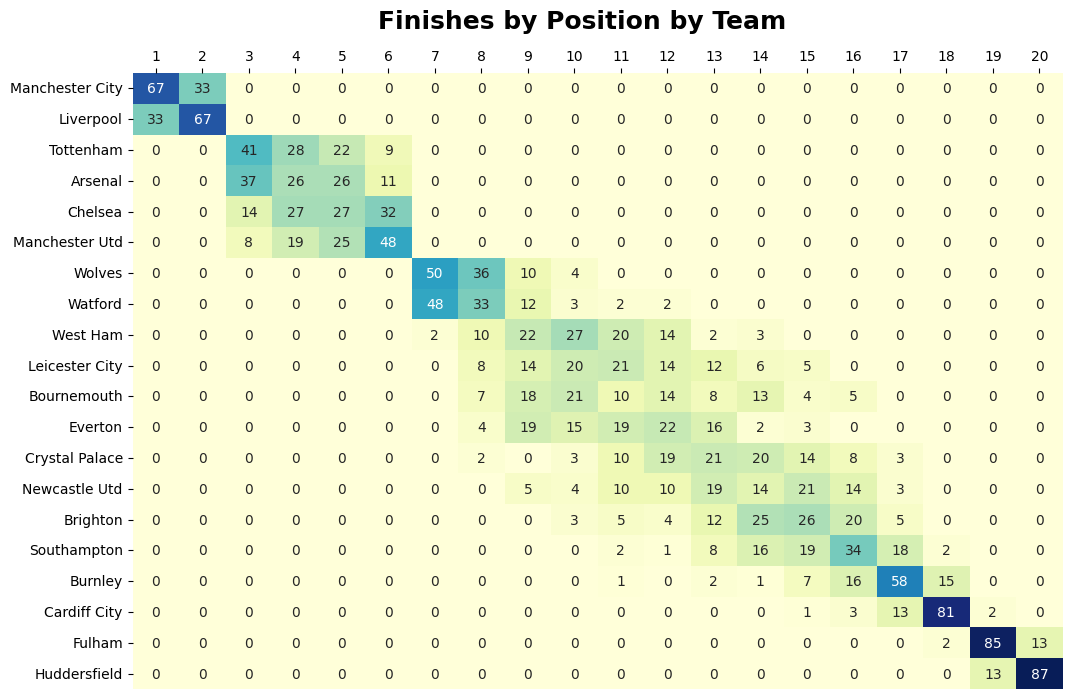

In [57]:
# Set the size of the heatmap
plt.figure(figsize=(12, 8))

# Plot the heatmap using the index for the y-axis
heatmap = sns.heatmap(team_positions, cmap="YlGnBu", annot=True, fmt="d", cbar=False)

# Set the title and labels
plt.suptitle('Finishes by Position by Team', y=0.96, weight='bold', size=18)
heatmap.xaxis.tick_top()
plt.xlabel('')
plt.ylabel('')
plt.show()

# Creating an ELO-based system

In [8]:
import pandas as pd

# Load match data from a CSV file
data = pd.read_csv("serbia.csv", encoding='latin1')

# Initialize ELO ratings and stats for each team
elo_ratings = {}
stats = {}

def initialize_team_stats(team):
    if team not in stats:
        stats[team] = {
            'matches': 0,
            'wins': 0,
            'draws': 0,
            'losses': 0,
            'goals_scored': 0,
            'goals_against': 0
        }

def get_elo(team):
    return elo_ratings.get(team, 1500)

def expected_score(elo_a, elo_b):
    return 1 / (1 + 10**((elo_b - elo_a) / 400))

def update_elo(winner_elo, loser_elo, k=32):
    expected_win = expected_score(winner_elo, loser_elo)
    expected_loss = expected_score(loser_elo, winner_elo)
    new_winner_elo = winner_elo + k * (1 - expected_win)
    new_loser_elo = loser_elo + k * (0 - expected_loss)
    return new_winner_elo, new_loser_elo

# Iterate over each match and update ELO ratings and stats
for index, row in data.iterrows():
    home_team = row['home']
    away_team = row['away']
    home_goals = row['gh']
    away_goals = row['ga']

    initialize_team_stats(home_team)
    initialize_team_stats(away_team)

    home_elo = get_elo(home_team)
    away_elo = get_elo(away_team)

    stats[home_team]['matches'] += 1
    stats[away_team]['matches'] += 1
    stats[home_team]['goals_scored'] += home_goals
    stats[away_team]['goals_scored'] += away_goals
    stats[home_team]['goals_against'] += away_goals
    stats[away_team]['goals_against'] += home_goals

    if home_goals > away_goals:  # Home team wins
        new_home_elo, new_away_elo = update_elo(home_elo, away_elo)
        stats[home_team]['wins'] += 1
        stats[away_team]['losses'] += 1
    elif home_goals < away_goals:  # Away team wins
        new_away_elo, new_home_elo = update_elo(away_elo, home_elo)
        stats[away_team]['wins'] += 1
        stats[home_team]['losses'] += 1
    else:  # Draw
        new_home_elo = home_elo + 32 * (0.5 - expected_score(home_elo, away_elo))
        new_away_elo = away_elo + 32 * (0.5 - expected_score(away_elo, home_elo))
        stats[home_team]['draws'] += 1
        stats[away_team]['draws'] += 1

    elo_ratings[home_team] = new_home_elo
    elo_ratings[away_team] = new_away_elo

# Convert the elo_ratings and stats dictionaries to a DataFrame for better visualization
elo_df = pd.DataFrame(elo_ratings.items(), columns=['Team', 'ELO Rating'])
stats_df = pd.DataFrame(stats).T.reset_index().rename(columns={'index': 'Team'})
final_df = elo_df.merge(stats_df, on='Team')
final_df = final_df.sort_values(by='ELO Rating', ascending=False)

# Display the final ELO ratings and stats
final_df

,Team,ELO Rating,matches,wins,draws,losses,goals_scored,goals_against
2,Red Star Belgrade,1983.618459,426,314,64,48,891,315
27,Radniki Nis,1781.902150,238,102,66,70,304,259
5,Partizan,1726.663914,426,300,73,53,859,301
14,FK Cukaricki Stankom,1678.908242,334,124,81,129,393,401
13,Mladost Lucani,1616.000819,211,75,61,75,246,265
12,FK Napredak,1564.235668,269,88,68,113,295,334
6,FK Hajduk Kula,1553.011842,218,64,59,95,194,248
21,Spartak Subotica,1549.001592,328,117,90,121,369,389
7,Vojvodina,1532.351737,426,205,106,115,583,402
28,Radnik Surdulica,1514.968182,148,46,36,66,156,218


In [19]:
import pandas as pd

# Load match data from a CSV file
data = pd.read_csv("serbia.csv", encoding='latin1')

# Initialize ELO ratings
initial_elo = 1500
ratings = {}

# Home advantage factor
home_advantage = 100

# Function to get ELO rating or initialize it
def get_elo(team):
    if team not in ratings:
        ratings[team] = initial_elo
    return ratings[team]

# Define K factor
K = 30

# Function to update ELO ratings
def update_elo(home_team, away_team, home_goals, away_goals):
    home_elo = get_elo(home_team)
    away_elo = get_elo(away_team)
    
    # Adjust home team rating with home advantage
    home_elo_adjusted = home_elo + home_advantage

    # Expected scores
    E_home = 1 / (1 + 10 ** ((away_elo - home_elo_adjusted) / 400))
    E_away = 1 / (1 + 10 ** ((home_elo_adjusted - away_elo) / 400))

    # Actual scores
    if home_goals > away_goals:
        S_home = 1
        S_away = 0
    elif home_goals < away_goals:
        S_home = 0
        S_away = 1
    else:
        S_home = 0.5
        S_away = 0.5

    # Update ratings
    new_home_elo = home_elo + K * (S_home - E_home)
    new_away_elo = away_elo + K * (S_away - E_away)

    ratings[home_team] = new_home_elo
    ratings[away_team] = new_away_elo

# Iterate over matches and update ELO ratings
for index, row in data.iterrows():
    # Get current ELO ratings before the match
    home_team = row['home']
    away_team = row['away']
    home_elo_before = get_elo(home_team)
    away_elo_before = get_elo(away_team)

    # Update homeELObefore and awayELObefore columns
    data.at[index, 'homeELO'] = home_elo_before
    data.at[index, 'awayELO'] = away_elo_before

    # Update the ELO ratings after the match
    update_elo(home_team, away_team, row['gh'], row['ga'])

# Display the final dataframe
data = data[['home', 'away', 'date', 'gh', 'ga', 'home_ident', 'away_ident', 'homeELO', 'awayELO']]
data

,home,away,date,gh,ga,home_ident,away_ident,homeELO,awayELO
0,FK Zemun,Ofk Beograd,2006-08-04,1,2,FK Zemun (Serbia),Ofk Beograd (Serbia),1500.000000,1500.000000
1,Red Star Belgrade,FK Vozdovac,2006-08-05,2,0,Red Star Belgrade (Serbia),FK Vozdovac (Serbia),1500.000000,1500.000000
2,FK Bezanija,Partizan,2006-08-05,3,4,FK Bezanija (Serbia),Partizan (Serbia),1500.000000,1500.000000
3,FK Hajduk Kula,Vojvodina,2006-08-05,1,0,FK Hajduk Kula (Serbia),Vojvodina (Serbia),1500.000000,1500.000000
4,FK Smederevo,Mladost Apatin,2006-08-05,1,2,FK Smederevo (Serbia),Mladost Apatin (Serbia),1500.000000,1500.000000
...,...,...,...,...,...,...,...,...,...
3214,FK Cukaricki Stankom,Vojvodina,2019-05-19,1,1,FK Cukaricki Stankom (Serbia),Vojvodina (Serbia),1689.859143,1534.988080
3215,Spartak Subotica,FK Vozdovac,2019-05-19,2,1,Spartak Subotica (Serbia),FK Vozdovac (Serbia),1538.156537,1513.972167
3216,FK Backa Backa Palanka,Fk Dinamo Vranje,2019-05-19,0,1,FK Backa Backa Palanka (Serbia),Fk Dinamo Vranje (Serbia),1418.139931,1448.112373
3217,Radnik Surdulica,Fk Macva Sabac,2019-05-19,3,0,Radnik Surdulica (Serbia),Fk Macva Sabac (Serbia),1497.342247,1492.530220


In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

home = data[['date', 'home_ident', 'away_ident', 'homeELO', 'awayELO', 'gh']].copy()
home.columns = ['Date', 'Team', 'Opponent', 'Team ELO', 'Opponent ELO', 'Team Goals']
home['Home Ground'] = 1

away = data[['date', 'away_ident', 'home_ident', 'awayELO', 'homeELO', 'ga']].copy()
away.columns = ['Date', 'Team', 'Opponent', 'Team ELO', 'Opponent ELO', 'Team Goals']
away['Home Ground'] = 0

home_away = pd.concat([home, away], axis=0)

X = home_away[['Team ELO', 'Opponent ELO', 'Home Ground']]
y = home_away['Team Goals']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Create and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['Importance'])
print(feature_importances)

Mean Squared Error: 1.301657157423399
R-squared: 0.03266880375800074
              Importance
Team ELO        0.524726
Opponent ELO    0.442370
Home Ground     0.032904


In [44]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

# Standardize features by scaling them
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the KNN regression model
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 1.27
R-squared: 0.05619493411064702
Mean Absolute Error: 0.8816770186335405
Root Mean Squared Error: 1.1269427669584644
